### Recover time information from multiple antennae

In [1]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(12345)
from scipy import signal as sgl

import os
import sys
# Append parent directory to import path so lib can be found
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

from lib import TravelSignal
from lib.sampling import Digitizer
from lib.location import Receiver, Emitter

import lib.sampling as smp
import lib.location as loc
import lib.util as util

km = 1e3
ns = 1e9

In [2]:
# Setup emitters and Antenna
############################
if True:
    emitter = Emitter([1,1])*km
else:
    emitter = Emitter([0,0])*km

# reference antenna
ref_ant = Receiver(np.array([2,2])*km)

# antenna circle
antennae = [
    Receiver( 5*km * util.rot_vector(np.pi*2/6* n)) for n in range(6)
]

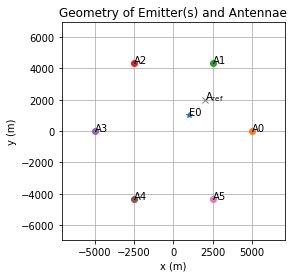

In [3]:
## Show Geometry
#################
if True:
    fig, ax = plt.subplots(1,1, figsize=(4,4))
    loc.plot_geometry(ax, [emitter], antennae)

    if True:
        ax.plot(*ref_ant.x, "x")
        ax.annotate("$\mathrm{A}_\mathrm{ref}$", ref_ant.x);

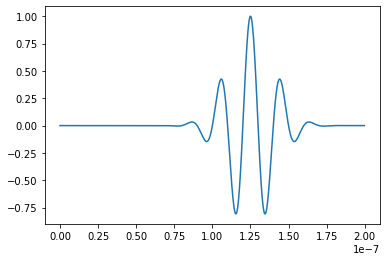

In [4]:
# Setup signal
########################

fc = 50e6# MHz
signal_t_length = 200e-9
signal_pulse_center = 125e-9 # 100 ns
signal_sample_rate = 5e9 # Hz
signal_time = util.sampled_time(
    sample_rate=signal_sample_rate,
    start=0,
    end=signal_t_length
)

analog_signal = TravelSignal(
    sgl.gausspulse(signal_time - signal_pulse_center, fc=fc),
    signal_sample_rate,
    t_0 = 0,
    periodic=False
)

del fc, signal_t_length, signal_pulse_center, signal_sample_rate

if True:
    fig, ax = plt.subplots()
    ax.plot(signal_time, analog_signal(signal_time))
    plt.show()
    
    
## the emitted signal
emitted = emitter.emit(analog_signal)

Spatial time offset emitter-antenna: 4717.31 ns


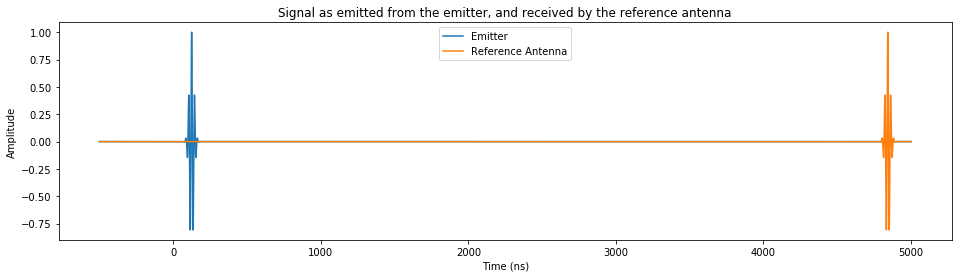

In [5]:
# Show how the signal is emitted
# and received by a reference antenna
########################

# analog time corresponds to a very high sampled time range
#  (to fully show the signal)
# that is sufficiently long to show both the emitted and received signal
if not True:
    t_start = 0
else:
    t_start = -50e-8

if not True:
    t_end = 5e-7 # ms
else:
    t_end = 50e-7 # ms
t_offset = 0 # 100 ns
sample_rate = 1e10 # 1/s

analog_time = util.sampled_time(sample_rate=sample_rate, start=t_start, end=t_end, offset=t_offset)


if True:
    # Figure
    fig, ax = plt.subplots(1, 1, figsize=(16,4))
    ax.set_title("Signal as emitted from the emitter, and received by the reference antenna")
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Time (ns)")

    ## Emitter
    received = emitter.recv(emitted)

    ax.plot(analog_time * ns,   received(analog_time), label="Emitter")


    ## Reference antenna
    received = ref_ant.recv(emitted)

    ax.plot(analog_time * ns,   received(analog_time), label="Reference Antenna")
    print("Spatial time offset emitter-antenna: {:.6g} ns".format(analog_signal.spatial_time_offset(emitter.x, ref_ant.x)*ns))

    ax.legend(loc='upper center')
    plt.show();

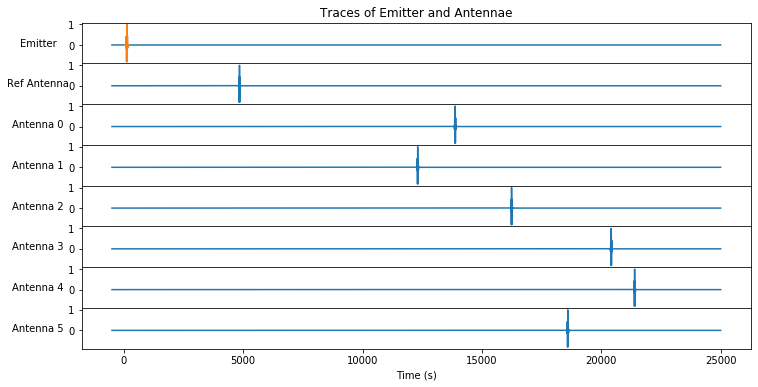

In [6]:
# Show absolute timing over all antennae
########################################

if True:
    longtime = util.sampled_time(
        sample_rate=sample_rate,
        start=t_start,
        end=5*t_end,
        offset=t_offset
    )

    ylabel_kw = {"rotation": "horizontal", "va":"center", "ha":"center", "labelpad": 30}
    
    fig, axs = plt.subplots(2+len(antennae), 1, sharex=True, figsize=(12,6), gridspec_kw={"hspace":0})
    axs[0].set_title("Traces of Emitter and Antennae")

    # Emitter
    i = 0
    axs[i].set_ylabel("Emitter".format(), **ylabel_kw)
    axs[i].set_xlabel("Time (ns)")
    axs[i].plot(longtime * ns, emitted(longtime), label="Emitter")
    axs[i].plot(signal_time * ns, emitted(signal_time), label="Signal time", zorder=2.5)

    # Reference Antenna
    i +=1
    axs[i].set_ylabel("Ref Antenna", **ylabel_kw)
    axs[i].plot(longtime * ns, ref_ant.recv(emitted)(longtime), label="Ref Antenna")
    axs[i].set_xlabel("Time (ns)")

    # Antenna
    for j, ant in enumerate(antennae):
        i +=1
        axs[i].set_ylabel("Antenna {}".format(j), **ylabel_kw)
        axs[i].plot(longtime * ns, ant.recv(emitted)(longtime), label="Antenna {}".format(j))
        axs[i].set_xlabel("Time (ns)")

Time delay ref ant -- emitter (ns): 9434.617346998737
T_threshold Emitter (ns): 123.0
T_threshold Antenna (ns): 9680.617346998737
Diff thresholds (ns): 9557.617346998737


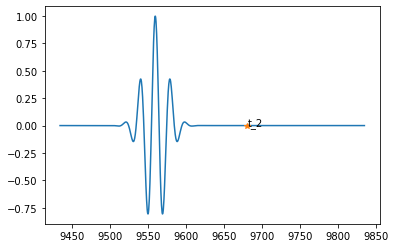

In [10]:
# Determine time from signal thresholds for emitter and reference receiver
######################################

threshold = 0.8

if True:
    mysignal = analog_signal
else:
    mysignal = emitted
    
received = ref_ant.recv(mysignal)
#received.periodic=True

## Recover signal time from signal
signal_time = util.sampled_time(sample_rate=mysignal.sample_rate, start=0, end=mysignal.time_length)

## Find time offset and recover approximate signal time at antenna
# Note: no idea where 2 comes from right now
time_offset = -2 * analog_signal.total_time_offset(x_f = ref_ant.x, x_0 = emitter.x, velocity = None)
ref_ant_signal_time = 2*signal_time + time_offset


# Find t_threshold for emitter
raw_emit = mysignal(signal_time)
t_thres_emit_idx = util.detect_edges(threshold, raw_emit, rising=True, falling=False)

if t_thres_emit_idx:
    t_thres_emit = signal_time[t_thres_emit_idx[0]]
else:
    t_thres_emit = None
del t_thres_emit_idx
    
    
# Find t_threshold for receiver
raw_ant = received(ref_ant_signal_time)
t_thres_ant_idx = util.detect_edges(threshold, raw_emit, rising=True, falling=False)

if t_thres_ant_idx:
    t_thres_ant = ref_ant_signal_time[t_thres_ant_idx[0]]
else:
    t_thres_ant = None
del t_thres_ant_idx

print("Time delay ref ant -- emitter (ns):", time_offset*ns)
print("T_threshold Emitter (ns):", t_thres_emit*ns)
print("T_threshold Antenna (ns):", t_thres_ant*ns)
print("Diff thresholds (ns):", (t_thres_ant - t_thres_emit)*ns)

## Make another plot
fig, ax = plt.subplots()
axs[i].set_xlabel("Time (ns)")
# Emitter
if not True:
    ax.plot(signal_time *ns,  raw_emit, label='Emitter')
    ax.plot(t_thres_emit*ns, mysignal(t_thres_emit), '*')
    ax.annotate("t_1", xy=(t_thres_emit*ns, mysignal(t_thres_emit)))

# Antenna
if True:
    ax.plot(ref_ant_signal_time*ns,   raw_ant, label="Reference Antenna")
    ax.plot(t_thres_ant*ns, received(t_thres_ant), '*')
    ax.annotate("t_2", xy=(t_thres_ant*ns, received(t_thres_ant)))

plt.show();